In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error,mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



In [2]:
X_train_1 =pd.read_csv("../data/X_train_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/X_train_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/X_train_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")

X_test =pd.read_csv("../data/X_test.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

In [3]:
x_train = X_train.copy()
x_test = X_test.copy()

Handling of the datetime in `month` col as decision tree cannot use datetime, we shall split it into `year` and `month_num` cols

In [4]:
x_train['month'] = pd.to_datetime(x_train['month'])
x_test['month'] = pd.to_datetime(x_test['month'])

# Extract year and month
x_train['year'] = x_train['month'].dt.year
x_train['month_num'] = x_train['month'].dt.month
x_test['year'] = x_test['month'].dt.year
x_test['month_num'] = x_test['month'].dt.month

# Drop the original 'month' column as no longer needed
x_train = x_train.drop(columns=['month'], errors='ignore')
x_test = x_test.drop(columns=['month'], errors='ignore')

We begin by implementing a Decision Tree because it serves as the base model for Random Forest. A decision tree is simple and easy to understand, making it a good starting point. However, decision trees can overfit, meaning they may perform well on training data but poorly on unseen data.

In addition to Linear Regression, which we previously used as a baseline model, we’ll now use the Decision Tree as another baseline. This gives us two points of comparison: a simple linear model (Linear Regression) and a more flexible, non-linear model (Decision Tree). While Linear Regression works well for linear relationships, a Decision Tree can capture more complex patterns in the data. However, Decision Trees tend to be sensitive to noise and may overfit without careful tuning.

Later, we'll implement a Random Forest, which improves upon decision trees by combining multiple trees to reduce overfitting and increase accuracy. By first understanding how a single decision tree performs, we can better appreciate the advantages of using an ensemble of trees in a random forest.

---

### **1.Decision Tree**

In [5]:
# Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

#### **Modelling**

In [6]:
# Fitting the Decision Tree model
dt_model.fit(x_train, y_train.values)

DecisionTreeRegressor(random_state=42)

In [7]:
# Predict on both training and test sets
y_train_pred = dt_model.predict(x_train)
y_test_pred = dt_model.predict(x_test)

# Calculate metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Training Set Evaluation:
  Root Mean Squared Error (Train): 6208.42992333899
  Mean Squared Error (Train): 38544602.11301098
  R^2 Score (Train): 0.9987102948824693

Test Set Evaluation:
  Root Mean Squared Error (Test): 35081.649147369804
  Mean Squared Error (Test): 1230722106.8991523
  R^2 Score (Test): 0.9589925306605487


#### **Decision Tree Model Evaluation**

Training Set Evaluation:  
The training RMSE is **6,208**, showing the model fits the training data very well (high accuracy). The R² score of **0.999** indicates it explains almost all of the variance in the training data, but this could be a sign of overfitting.

Test Set Evaluation:  
The test RMSE is **35,082**, which is much higher than the training RMSE. This indicates that the model does not generalise as well on unseen data. The test R² score of **0.959** shows that the model still performs reasonably well on the test data, but the higher test RMSE compared to the training RMSE suggests that the model is overfitting.

Conclusion:  
The large gap between the training and test RMSE suggests that the decision tree is fitting the training data too closely, leading to overfitting. While it performs well on the training data, its ability to generalise to new data might be limited. Using this decision tree as the baseline model, the next step will be to implement **Random Forest**, which can help mitigate overfitting by averaging predictions from multiple trees.

In [8]:
# Perform cross-validation
scores = cross_val_score(dt_model, x_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print RMSE values as a list
print(f"RMSE for each fold: {list(rmse_scores)}")

# Calculate and print the mean RMSE
mean_rmse = rmse_scores.mean()
print(f"Mean RMSE (across all folds): {mean_rmse}")

RMSE for each fold: [36887.76416063697, 36528.43666312486, 37095.30469195377, 36075.72741080662, 37343.7786539256]
Mean RMSE (across all folds): 36786.20231608956


The decision tree shows reasonable generalising as the RMSE values from cross-validation (around 36,786) and the test set (35,081) are quite similar, indicating the model performs consistently on both the training data (through cross-validation) and unseen data (test set). However, both RMSE values are still relatively high compared to the training RMSE (6208), suggesting some overfitting.

#### **Visualistion**

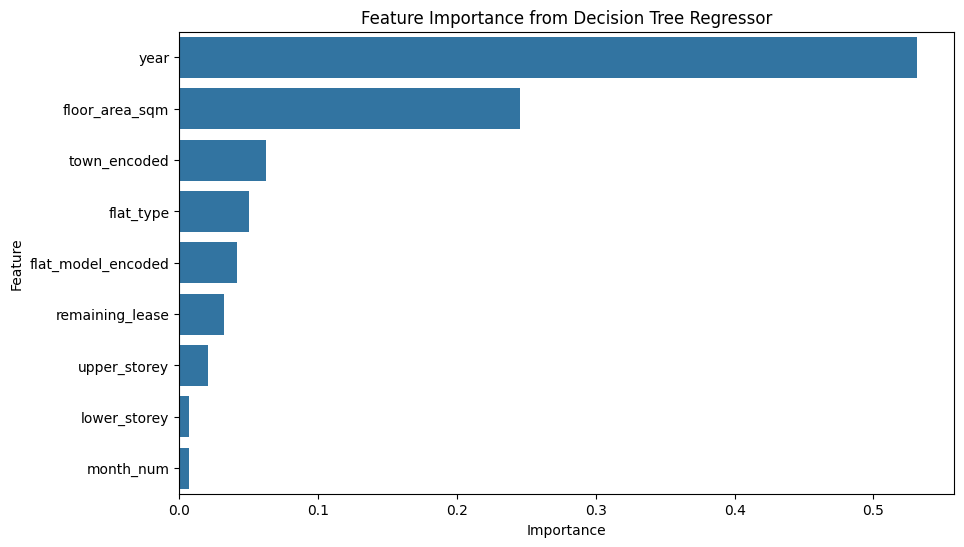

In [9]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance from Decision Tree Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

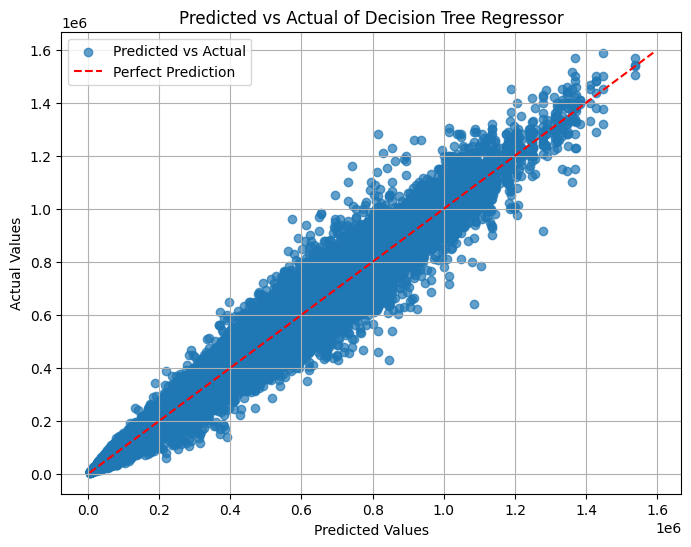

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual of Decision Tree Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

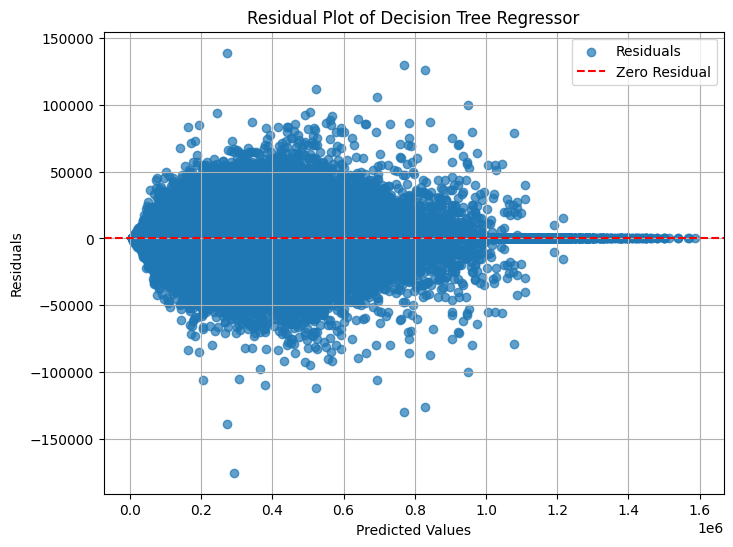

In [11]:
y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot of Decision Tree Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

We can see that the residual is evenly distributed up till a point. At the higher prices, the model start to overfit as residuals are close to zero. This suggests that the decision tree is overfitting to higher-priced data points, likely due to its tendency to create overly specific splits in areas where data is sparse. This overfitting results in low residuals for higher prices in the training data but can lead to poor generalisation and higher errors on unseen data in this range as shown with the large difference in training and test RMSE.

### **2.Random Forest**

Now that we've implemented and evaluated a **Decision Tree**, we will now implement **Random Forest**. It is an ensemble method that combines multiple decision trees to reduce overfitting and improve generalisation. By averaging the predictions of many trees, Random Forest mitigates the risk of a single tree's overfitting to the training data, leading to more accurate and stable predictions. We will implement a Random Forest model and compare its performance to that of the Decision Tree.

Similar to decision tree, random Forest is suitable for this prediction task and dataset due to its robustness to outliers and noise in dataset, ability to provide feature importance score, which provide interpretability of the model, and the capability to handle non-linear relationship between the features.

In [12]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#### **Modelling**

In [13]:
# Fitting the RandomForest model
rf_model.fit(x_train, y_train.values.ravel())

RandomForestRegressor(random_state=42)

In [14]:
# Predict on both training and test sets
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Calculate metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Training Set Evaluation:
  Root Mean Squared Error (Train): 11190.725411486885
  Mean Squared Error (Train): 125232335.23529829
  R^2 Score (Train): 0.995809717190497

Test Set Evaluation:
  Root Mean Squared Error (Test): 26548.68789523073
  Mean Squared Error (Test): 704832828.9583708
  R^2 Score (Test): 0.9765150796748323


#### **Random Forest Model Evaluation**

Training Set Evaluation:  
The training RMSE is **11,191**, indicating that the model fits the training data well, but not as closely as the decision tree. The R² score of **0.996** suggests the model explains a large proportion of the variance in the training data, this could be sign it is overfitting, but it overfit lesser compared to the decision tree.

Test Set Evaluation:  
The test RMSE is **26,549**, which is still higher than the training RMSE, but significantly lower than that of the decision tree model. The test R² score of **0.977** indicates that the model performs well on unseen data, with a reasonably smaller gap between training and test performance compared to decision tree, suggesting that random forest generalises better than the decision tree.

Conclusion:  
The Random Forest model shows improved generalisation compared to the decision tree, with a smaller difference between training and test RMSE. While the training RMSE of random forest is higher than the decision tree, the test RMSE is much closer to the training RMSE, indicating less overfitting. The Random Forest model’s ability to combine predictions from multiple trees helps reduce the overfitting seen with the decision tree, making it a more robust model for this dataset as compared to decision tree.

#### **Visualistion**

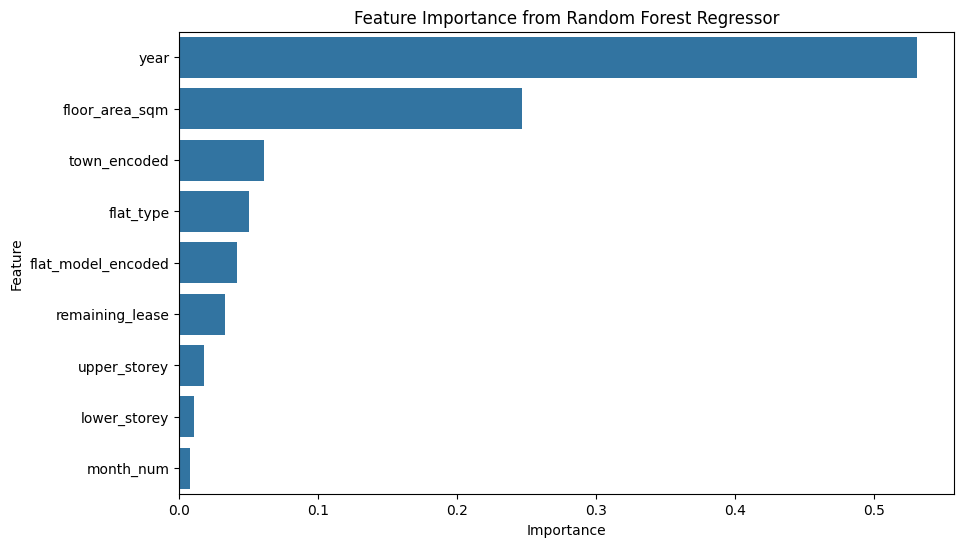

In [15]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

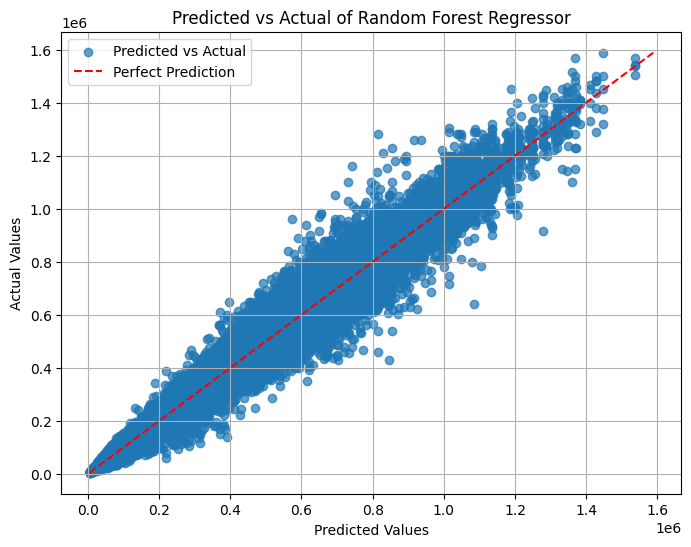

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual of Random Forest Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

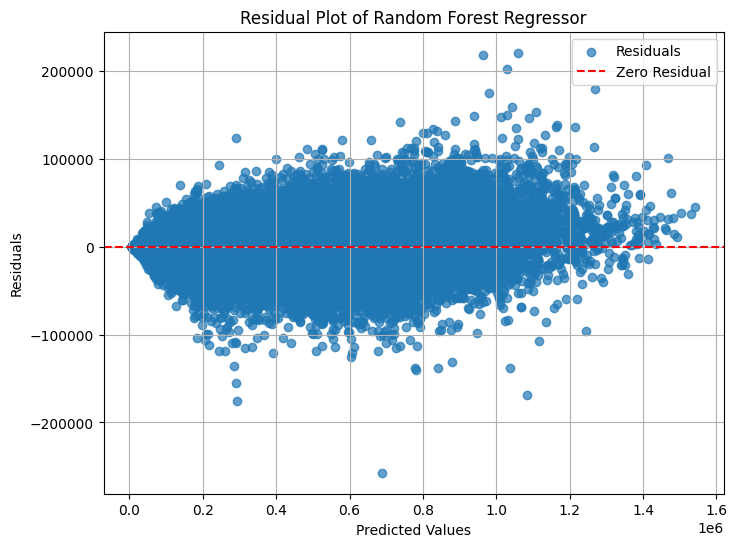

In [17]:
y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot of Random Forest Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

Comparing the residual plots of the decision tree and random forest, we can see that the residuals of the random forest model are more evenly distributed across the range of predicted values, while the decision tree residuals are clustered more tightly and show consistently low values at higher predicted prices. This suggests that the decision tree may be overfitting at higher price ranges, capturing noise in the training data. In contrast, the random forest, with its more uniform residual distribution, demonstrates better generalisation despite its slightly larger residual range. Hence the random forest has improved model performance compared to decision tree as seen by the smaller difference between the training and test RMSE and better test R^2.

---

### **Hyperparameter Tuning**

##### **Decision Tree Hyperparameter Tuning**

In [18]:
# Define the Decision Tree Regressor
dt_model1 = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_model1,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error', # Optimize for RMSE
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters and model
best_params_dt = grid_search.best_params_
best_model_dt = grid_search.best_estimator_

# Predictions
y_train_pred = best_model_dt.predict(x_train)
y_test_pred = best_model_dt.predict(x_test)

# Evaluate on training data
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on test data
rmse_test = root_mean_squared_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {best_params_dt}")

print(f"\nTraining Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Training Set Evaluation:
  Root Mean Squared Error (Train): 20492.1100270035
  Mean Squared Error (Train): 419926573.3588174
  R^2 Score (Train): 0.9859492271042235

Test Set Evaluation:
  Root Mean Squared Error (Test): 31486.00189691453
  Mean Squared Error (Test): 991368315.4525054
  R^2 Score (Test): 0.9669677617943745


Tuning the decision tree reduced overfitting by increasing the training RMSE from **6,208** to **20,492**. This happened because hyperparameter tuning found a less complex model with the best parameters, such as larger min_samples_leaf and larger min_samples_split. These changes limited how deeply the tree could grow, preventing it from overfitting to noise in the training data. As a result, the test RMSE improved from **35,081** to **31,486**, and the test R² score increased from **0.959** to **0.967**. This shows that the tuned model balances complexity and generalisation better than the default configuration.

In [19]:
# Initialize the decision tree model with the best parameters and random_state
dt_model_tuned = DecisionTreeRegressor(**best_params_dt, random_state=42)

# Perform cross-validation with the tuned model
scores = cross_val_score(dt_model_tuned, x_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print RMSE values as a list
print(f"RMSE for each fold: {list(rmse_scores)}")

# Calculate and print the mean RMSE
mean_rmse = rmse_scores.mean()
print(f"Mean RMSE (across all folds): {mean_rmse}")

RMSE for each fold: [33001.44071003202, 33107.47255216683, 33540.68338739034, 32411.19916240874, 33673.57969702239]
Mean RMSE (across all folds): 33146.875101804064


The decision tree with hyperparameter tuning shows reasonable generalising as the RMSE values from cross-validation (around 33,146) and the test set (31,486) are quite similar, indicating the model performs consistently on both the training data (through cross-validation) and unseen data (test set).

##### **Random Forest Hyperparameter Tuning**

RandomizedSearchCV is used to efficiently tune hyperparameters without taking too much time, especially since the default Random Forest iteration already takes about 9 minutes due to the dataset size and model complexity. The default settings for Random Forest are already very strong, achieving an R² of 0.9958 on the training set and 0.9765 on the test set. Tuning using parameters that reduce model complexity is still done to try and improve the model further and make sure it performs well on unseen data.

In [23]:
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10], 
    'max_features': ['sqrt', 'log2', None]
}

# Random Forest model
rf_model1 = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for fewer iterations and reduced grid size
random_search = RandomizedSearchCV(
    estimator=rf_model1,
    param_distributions=param_dist,
    n_iter=20,
    cv=2,
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(x_train, y_train.values.ravel())

# Get the best parameters and model
best_params_rf = random_search.best_params_
best_model_rf = random_search.best_estimator_

# Predictions
y_train_pred = best_model_rf.predict(x_train)
y_test_pred = best_model_rf.predict(x_test)

# Evaluate on training data
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on test data
rmse_test = root_mean_squared_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {best_params_rf}")

print(f"\nTraining Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': None, 'max_depth': 30}

Training Set Evaluation:
  Root Mean Squared Error (Train): 14396.337809813085
  Mean Squared Error (Train): 207254542.33425382
  R^2 Score (Train): 0.9930652483298112

Test Set Evaluation:
  Root Mean Squared Error (Test): 26217.733232861057
  Mean Squared Error (Test): 687369535.869467
  R^2 Score (Test): 0.9770969538866423


Hyperparameter tuning resulted in the best parameters found to have larger min_samples_split and a smaller max_depth as compared to the default settings. However this tuned random results resulted in only minimal improvement, with test RMSE and R² values remaining almost unchanged before and after tuning. Given the negligible gains, the time spent on tuning does not justify the effort. This suggests that the default RandomForestRegressor settings is already well-optimized for the dataset. Rather than focusing time on hypertuning to improve random forest performance, it might be more beneficial to focus on further feature engineering and additional data like deriving proximity to nearest mrt station based on the street name, etc.

---

### **Decision Tree vs Random Forest Model**

**Why Random Forest Performs Better**

1. **Ensemble Learning:**  
   Random forest combines the predictions of multiple decision trees, reducing the impact of individual tree errors. By averaging these predictions, it minimizes overfitting and improves overall model performance.

2. **Better Generalisation:**  
   The averaging process in random forest smooths out predictions, allowing the model to generalise better to unseen data compared to a single decision tree.

**Trade-offs**

1. **Training and Prediction Time:**  
   Random forest is computationally heavier than a single decision tree due to the need to train multiple trees and aggregate their predictions. While decision trees are faster to train and predict, random forest sacrifices speed for improved performance.

2. **Memory Usage:**  
   Random forest requires storing multiple trees in memory, which can become computationally expensive for large datasets or when a high number of trees is used.

3. **Interpretability:**  
   Decision trees are easier to interpret as they provide a single, clear tree structure. In contrast, random forest is harder to interpret since it aggregates results from many trees, making it challenging to understand individual feature contributions.

**Summary of Results after tuning**

- **Random Forest:**  
  - **R²: 0.977** Higher than decision tree, indicating better generalisation.  
  - **RMSE: 26217** Lower than decision tree, showing more accurate predictions and reduced errors on unseen data.  

- **Decision Tree:**  
  - **R²: 0.967** Lower, as the model does not generalise to unseen data as well as random forest.
  - **RMSE: 31486** Higher, reflecting larger errors due to overfitting.